# CNN_MNIST

In [2]:
import tensorflow as tf
from tensorflow import keras

import sys
import numpy as np
import cv2

print('opencv version = ', cv2.__version__)
print('tensorflow version = ', tf.__version__)

opencv version =  4.5.5
tensorflow version =  2.6.0


In [ ]:
# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.random.set_seed(3)

In [ ]:
# 데이터 불러오기

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)

In [ ]:
## Convolution 신경망
model =  keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 1),
                              activation = 'relu'))
model.add(keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size = 2))
# model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

In [ ]:
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

In [ ]:
modelpath="./model/{epoch:003d}-{val_loss:.4f}.h5"
checkpointer = keras.callbacks.ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test),
                    epochs = 30, batch_size = 200, verbose = 1,
                    callbacks = [early_stopping_callback, checkpointer])

In [ ]:
## model import
print('\n Test accuracy: {:.4f}%'.format(model.evaluate(X_test, Y_test)[1]))

In [ ]:
# model = keras.models.load_model('./model_mnist/')
model.save('./model_mnist/', include_optimizer=False)

In [ ]:
!pip install -U tf2onnx

In [ ]:
!python -m tf2onnx.convert --saved-model model_mnist --output model_mnist.onnx

# opencv

4.0 2.0 10.0
0.5 2.5


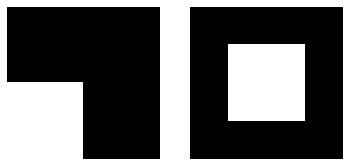

In [55]:
import matplotlib.pyplot as plt
# img = cv2.imread('./googlenet/fig/apple2.png', 0)
img = np.zeros((4,4), np.uint8)
img[2:, :2] = 1
# _, img = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY_INV)
m = cv2.moments(img)

print(m['m00'], m['m10'], m['m01'] )
cx = m['m10'] / m['m00']
cy = m['m01'] / m['m00']
print(cx, cy)
h, w = img.shape[:2]
# print(h, w)
# # # affine 행렬 생성
aff = np.array([[1, 0, w/2 - (cx + 0.5) ], [0, 1, h/2 - (cy + 0.5)]], dtype=np.float32)

# # # warpAffine을 이용해 기하학 변환
dst = cv2.warpAffine(img, aff, (0, 0))

plt.subplot(121),plt.imshow(img, 'gray'),plt.axis('off')
plt.subplot(122),plt.imshow(dst, 'gray'),plt.axis('off')
plt.show()

In [57]:
def on_mouse(event, x, y, flags, _):
    global oldx, oldy

    if event == cv2.EVENT_LBUTTONDOWN:
        oldx, oldy = x, y

    elif event == cv2.EVENT_LBUTTONUP:
        oldx, oldy = -1, -1

    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.line(img, (oldx, oldy), (x, y), (255, 255, 255), 20, cv2.LINE_AA)
            oldx, oldy = x, y
            cv2.imshow('img', img)

            
def norm_digit(img):
    # 무게 중심 좌표 추출
    m = cv2.moments(img)
    cx = m['m10'] / m['m00']
    cy = m['m01'] / m['m00']
    h, w = img.shape[:2]
    
    # affine 행렬 생성
    aff = np.array([[1, 0, w/2 - (cx + 0.5)], [0, 1, h/2 - (cy + 0.5)]], 
                   dtype=np.float32)
    
    # warpAffine을 이용해 기하학 변환
    dst = cv2.warpAffine(img, aff, (0, 0))
    return dst

net = cv2.dnn.readNet('./self_trained_mnist/model.onnx')
# net = cv2.dnn.readNet('./self_trained_mnist/model_no_opset.onnx')


if net.empty():
    print('Network load failed!')
    sys.exit()

img = np.zeros((400, 400), np.uint8)

cv2.imshow('img', img)
cv2.setMouseCallback('img', on_mouse)

while True:
    key = cv2.waitKey()

    if key == 27:
        break
        
    elif key == ord(' '):
        blob = cv2.dnn.blobFromImage(norm_digit(img), 1/255., (28, 28))
        net.setInput(blob)
        prob = net.forward()

        _, maxVal, _, maxLoc = cv2.minMaxLoc(prob)
        digit = maxLoc[0]

        print(f'{digit} ({maxVal * 100:4.2f}%)')

        img.fill(0)
        cv2.imshow('img', img)

cv2.destroyAllWindows()

5 (51.76%)
6 (94.08%)
7 (99.98%)
8 (99.96%)
1 (99.81%)
2 (99.98%)
3 (100.00%)
4 (100.00%)
5 (100.00%)
6 (99.88%)
7 (100.00%)
8 (100.00%)
9 (100.00%)
6 (97.36%)
2 (95.82%)
3 (99.82%)
